# Demand Estimation
* The difference between total sales and demand (shortage) is that $sales = min(inventory, demand)$, so sales is not equal to demand when there is less inventory. In fact, the difference is caused by shortage in some items. In part 1, this difference is also calculated based on estimated value of demands.
* We need the demand of sold-out items to find the optimum pricing for maximum sales revenues.

# Clustering
In this part, the clustering is studied for different number of clusters. The characterstics of clusters are plotted afterwards. First, the dataset is read and 1000 random items are extracted from the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy

In [2]:
df = (pd.read_excel("Flashion_Data_Part1.xlsx")
      .sample(axis=0, n=1000))
df.head()

,Item#,Total sales,hour 1,hour 2,hour 3,hour 4,hour 5,hour 6,hour 7,hour 8,...,hour 15,hour 16,hour 17,hour 18,hour 19,hour 20,hour 21,hour 22,hour 23,hour 24
1896,1897,4585,0.131395,0.080879,0.066586,0.025892,0.013903,0.002402,0.009549,0.007811,...,0.048231,0.034797,0.045927,0.026615,0.036808,0.012809,0.020933,0.019117,0.017398,0.038878
2067,2068,3192,0.131187,0.065305,0.018804,0.006396,0.003953,0.043125,0.070164,0.050674,...,0.026023,0.042494,0.042384,0.032200,0.029537,0.044635,0.008125,0.049027,0.042905,0.013780
1851,1852,5956,0.108894,0.022974,0.018909,0.057650,0.060791,0.067997,0.064794,0.075326,...,0.029564,0.036709,0.025930,0.021372,0.000000,0.001109,0.023158,0.016999,0.023405,0.007822
2440,2441,4307,0.124569,0.061082,0.064472,0.019686,0.013780,0.011210,0.017663,0.021327,...,0.026248,0.028600,0.036146,0.026084,0.026904,0.039646,0.012632,0.046590,0.036474,0.006289
81,82,2865,0.142364,0.016370,0.073311,0.048030,0.014407,0.023868,0.003474,0.057216,...,0.027480,0.038471,0.025065,0.032426,0.038511,0.002297,0.023142,0.022671,0.033584,0.041160


To identify sold-out items which require estimation of demand, total sales percent is calculated. The items for which the total sales percent has reached 100% before hour 24, there is an excess in demand. This criteria for sold-out items is implemented in the demand function later. 

In [3]:
df = (df
      .assign(sales_percent=lambda df:
              df.loc[:, df.columns.str.startswith("hour ")].sum(axis=1))
      .assign(soldout=lambda df:
              ((df.sales_percent>=0.99) & (df["hour 24"]==0)))
     )
df.head()

,Item#,Total sales,hour 1,hour 2,hour 3,hour 4,hour 5,hour 6,hour 7,hour 8,...,hour 17,hour 18,hour 19,hour 20,hour 21,hour 22,hour 23,hour 24,sales_percent,soldout
1896,1897,4585,0.131395,0.080879,0.066586,0.025892,0.013903,0.002402,0.009549,0.007811,...,0.045927,0.026615,0.036808,0.012809,0.020933,0.019117,0.017398,0.038878,0.805729,False
2067,2068,3192,0.131187,0.065305,0.018804,0.006396,0.003953,0.043125,0.070164,0.050674,...,0.042384,0.032200,0.029537,0.044635,0.008125,0.049027,0.042905,0.013780,1.000000,False
1851,1852,5956,0.108894,0.022974,0.018909,0.057650,0.060791,0.067997,0.064794,0.075326,...,0.025930,0.021372,0.000000,0.001109,0.023158,0.016999,0.023405,0.007822,0.964339,False
2440,2441,4307,0.124569,0.061082,0.064472,0.019686,0.013780,0.011210,0.017663,0.021327,...,0.036146,0.026084,0.026904,0.039646,0.012632,0.046590,0.036474,0.006289,0.832668,False
81,82,2865,0.142364,0.016370,0.073311,0.048030,0.014407,0.023868,0.003474,0.057216,...,0.025065,0.032426,0.038511,0.002297,0.023142,0.022671,0.033584,0.041160,0.997919,False


To estimate the demand of sold-out items, we use the sales behavior of similar items. The similarity is considered in terms of similar hourly percent of sales. For this purpose, first, the items with known demand are clustered, then the sold-out items are associated with these clusters and their demand is estimated.

## K-means clustering for different ks
K-means clustering for various values of k=2,3,4,5 is performed.
* As shown in the plot of total within sum of squares, the increase in number of clusters (k) has reduced the sum of squares as expected. The decline is almost linear.
* As the number of clusters increases, the average linkage decreases.

In [4]:
kmeanss = list()
for k in range(2,6):
    kmeans = KMeans(n_clusters=k, n_init="auto")
    kmeans.fit(df.loc[df.soldout==False, df.columns.str.startswith("hour ")])
    kmeanss.append(kmeans)

## Plotting SSE and average distance in clusters

Text(0, 0.5, 'Sum of squares')

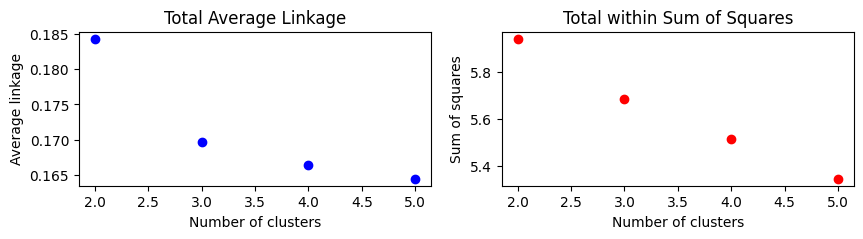

In [5]:
SS = list(range(len(kmeanss)))
avg_link = list(range(len(kmeanss)))
for k, kmean in enumerate(kmeanss):
    items_clusters = kmean.predict(df.loc[:, df.columns.str.startswith("hour ")])
    SS[k] = kmean.inertia_
    
    # Calculate average linkage for all clusters
    sum_link = 0
    n_link = 0
    clusters = list(range(kmean.n_clusters))
    items_array = np.array(df.iloc[:,2:26])
    for item_i in range(len(items_clusters)):
        for item_j in range(len(items_clusters)):
            if (item_i!=item_j) and (items_clusters[item_i]!=items_clusters[item_j]):
                sum_link += np.sqrt(np.sum(np.square(items_array[item_i, :]-items_array[item_j, :])))
                n_link += 1
    avg_link[k] = sum_link / n_link


fig, axs = plt.subplots(1,2, figsize=(10, 2))
cluster_labels = ["Cluster {}".format(i+1) for i in range(kmean.n_clusters)]
axs[0].scatter([kmean.n_clusters for kmean in kmeanss], avg_link, color="blue")
axs[0].set_title("Total Average Linkage")
axs[0].set_xlabel("Number of clusters")
axs[0].set_ylabel("Average linkage")
axs[1].scatter([kmean.n_clusters for kmean in kmeanss], SS, color="red")
axs[1].set_title("Total within Sum of Squares")
axs[1].set_xlabel("Number of clusters")
axs[1].set_ylabel("Sum of squares")

## Visualization of estimated demand for different k

The comparison of estimated demands for various number of clusters shows negligible difference for different number of clusters as shown in the following scatter plot.

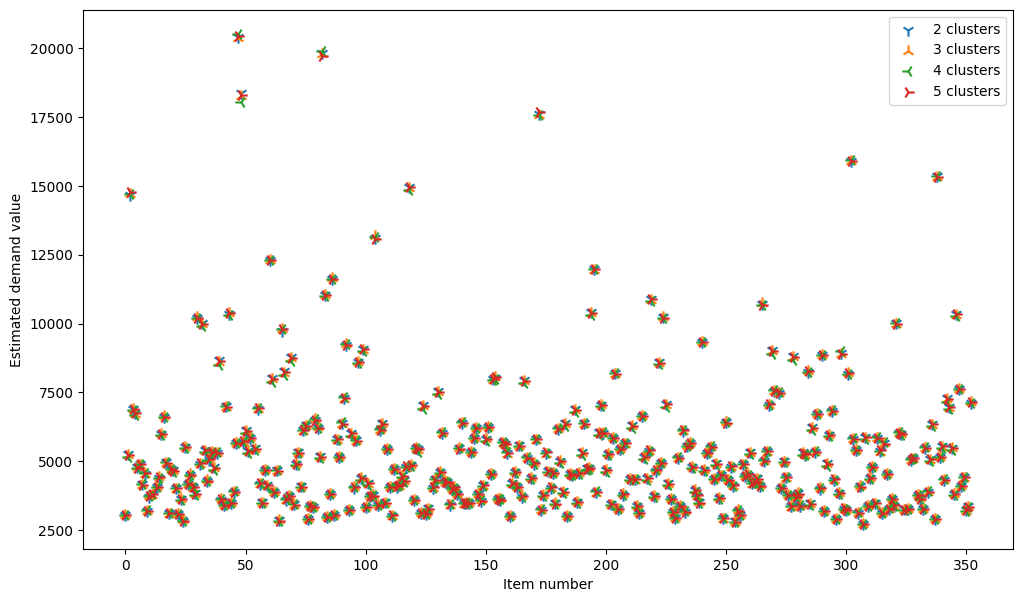

In [6]:
def demand(row, df_c):
    if row["soldout"]:
        sales_sum_percent = 0
        for hour in range(1,25):
            column = "hour {}".format(hour)
            sales_sum_percent += row[column]
            if sales_sum_percent >= 0.999:
                unsold_sum_percent = (df_clusters.loc[row["cluster"], "hour 24"] -
                                      df_clusters.loc[row["cluster"], column])
                row["demand"] = row["Total sales"]/(1-unsold_sum_percent)
                break
    else:
        row["demand"] = row["Total sales"]
    return row


fig, ax = plt.subplots(figsize=(12,7))
marker_map = {2:"1", 3:"2", 4:"3", 5:"4"}

demands_array = np.empty((len(df),4))
for idx, k in enumerate(range(2,6)):
    kmeans = KMeans(n_clusters=k, n_init="auto")
    kmeans.fit(df.loc[df.soldout==False, df.columns.str.startswith("hour ")])
    df = df.assign(cluster=lambda df:
               kmeans.predict(df.loc[:, df.columns.str.startswith("hour ")]))
    
    df_clusters = (df
                   .query("soldout==False")
                   .groupby(["cluster"])
                   .mean()
                  )
    
    for hour in range(2,25):
        column_i = "hour {}".format(hour)
        column_i_1 = "hour {}".format(hour-1)
        df_clusters.loc[:, column_i] = df_clusters.loc[:, column_i]+df_clusters.loc[:, column_i_1]
        
    df = (df
          .apply(demand, axis=1, df_c=df_clusters)
          .assign(shortage=lambda df: df["demand"]-df["Total sales"])
         )
    demands_array[:, idx] = df["demand"]
    ax.scatter(range(len(df.loc[df.soldout])), df.loc[df.soldout, "demand"],
               marker=marker_map[kmeans.n_clusters],
               label="{} clusters".format(kmeans.n_clusters),
              s=80)
    ax.legend()
    ax.set_xlabel("Item number")
    ax.set_ylabel("Estimated demand value")
coeff_vars = 100*scipy.stats.variation(demands_array, axis=1)

To evaulate the variations in the estimated demands caused by different number of clusters, the coefficient of variation $CV=\frac{\sigma}{\mu}$ is evaulated for each item. The distribution of CV is provided in percentage in the following plot.

Text(0.5, 1.0, 'Distribution of coefficient of variation of the estimated item demands\n (variations are caused by number of clusters)')

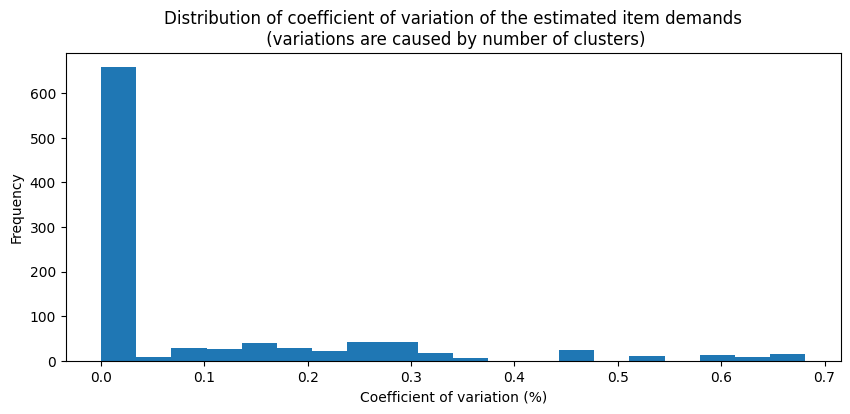

In [7]:
fig, ax = plt.subplots(figsize=(10,4))
ax.hist(coeff_vars, bins=20)
ax.set_ylabel("Frequency")
ax.set_xlabel("Coefficient of variation (%)")
ax.set_title("Distribution of coefficient of variation of the estimated item demands\n (variations are caused by number of clusters)")

In [8]:
coeff_vars = [0 if np.isnan(coeff_vars[i]) else coeff_vars[i] for i in range(len(coeff_vars))]
idx_maxcv = np.argmax(coeff_vars)
print("The item with maximum coefficient of variation is the {}th with estimated values of:\n{}"
      .format(idx_maxcv, demands_array[idx_maxcv]))

The item with maximum coefficient of variation is the 833th with estimated values of:
[4937.72409031 4907.06589385 4847.57688128 4916.18128502]


## Recommendation for the number of clusters k

As shown in the plot above the relative variation caused by different number of clusters is negligible. So each value of k can be used for estimation of demand. 